Spike trains are generated using univariate, self‐exciting Hawkes point process with an exponential kernel, using Ogata’s thinning algorithm. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from datetime import datetime

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import func_single_exp_monkey, fit_single_exp
from calculate_acf import acf_sttc
from spike_train_utils import bin_spike_train_fixed_len
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [19]:
dataset_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic_data\\results\\param_fr_alpha\\'
fig_folder = project_folder_path + 'results\\synthetic_data\\fig_drafts_paper\\'

In [77]:
save_fig = False

#### Load spike trains

In [ ]:
# rate_hz     = 3.5     # target firing rate (Hz)
# tau_ms      = 100.0    # desired autocorr time constant (ms)
# alpha       = 0.3      # self‐excitation weight (must be <1)

In [78]:
with open(dataset_folder + 'spike_trains_tau100ms_alpha_var_fr_var_len600sec_10000.pkl','rb') as f:
    data = pickle.load(f)

all_spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']

print(f'n spike trains {len(all_spike_trains)}, len {all_spike_trains[0][-1]/1000}')


duration_ms = 600 * 1000
#target_fr_hz = 3.5
target_tau_ms = 100

fs = 1000

n spike trains 10000, len 599.9437707242782


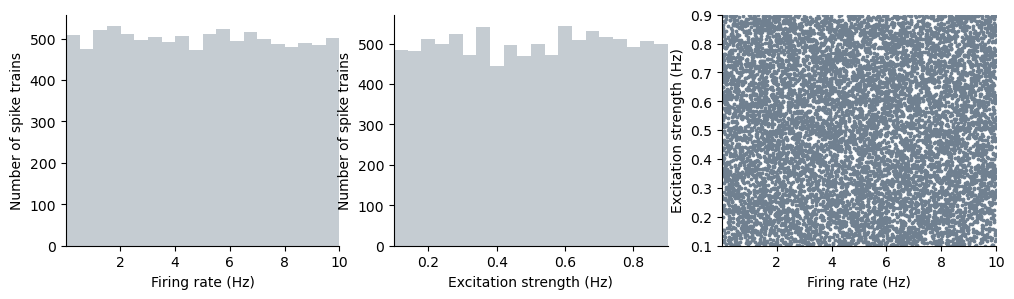

In [79]:
# Compute firing rates (Hz)
rates = fr_values

fig, axes = plt.subplots(1,3, figsize=(12,3))

axes[0].hist(rates, bins=20, color='slategray', alpha=0.4)
#axes.axvline(x=target_fr_hz, color='salmon', label='target FR')
#axes.axvline(x=np.median(rates), color='steelblue', label='generated FR (median)')
axes[0].set_xlabel('Firing rate (Hz)')
axes[0].set_ylabel('Number of spike trains')
# axes.set_title(f'Target FR {target_fr_hz}Hz, \nmedian FR {np.round(np.median(rates),4)}Hz')
axes[0].set_xlim([0.01,10])

axes[1].hist(alphas, bins=20, color='slategray', alpha=0.4)
#axes.axvline(x=target_fr_hz, color='salmon', label='target FR')
#axes.axvline(x=np.median(rates), color='steelblue', label='generated FR (median)')
axes[1].set_xlabel('Excitation strength (Hz)')
axes[1].set_ylabel('Number of spike trains')
# axes.set_title(f'Target FR {target_fr_hz}Hz, \nmedian FR {np.round(np.median(rates),4)}Hz')
axes[1].set_xlim([0.1,0.9])

axes[2].scatter(rates, alphas, s=3, color='slategray')
axes[2].set_ylabel('Excitation strength (Hz)')
axes[2].set_xlabel('Firing rate (Hz)')
axes[2].set_ylim([0.1,0.9])
axes[2].set_xlim([0.01,10])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'dataset_fr_alpha_var.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'dataset_fr_alpha_var.svg' , bbox_inches='tight')

#### Calculate acf and taus

##### ACFs

In [80]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

bin_size = int(50 * (fs / 1000))
sttc_dt = int(25 * (fs / 1000))

calc_acf_full = True
calc_isttc_full = True

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [81]:
all_spike_trains_binned_l = []
for i in range(len(all_spike_trains)):
    binned_spike_train = bin_spike_train_fixed_len([int(spike) for spike in all_spike_trains[i]],
                                                   bin_size, fs, duration_ms,
                                                   verbose_=False)
    all_spike_trains_binned_l.append(binned_spike_train)

In [82]:
if calc_acf_full:
    acf_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains_binned_l):
        if unit_idx % 1000 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_binned_acf = acf(unit, nlags=n_lags)
        acf_full_l.append(spike_train_binned_acf)
    
    acf_full_df = pd.DataFrame(np.array(acf_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_full_df.isnull().any().any()))
    acf_full_df.head(3)
    
    # acf_full_df.to_pickle(dataset_folder + 'cut_30min\\binned\\acf\\acf_full_50ms_20lags_df.pkl')

Processing unit 0
Processing unit 1000
Processing unit 2000
Processing unit 3000
Processing unit 4000


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Processing unit 5000
Processing unit 6000
Processing unit 7000
Processing unit 8000
Processing unit 9000
NaNs in acf True


In [83]:
if calc_isttc_full:
    acf_isttc_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains):
        if unit_idx % 1000 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_int = np.asarray([int(spike) for spike in unit])
        spike_train_acf = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, duration_ms, verbose_=False)
        acf_isttc_full_l.append(spike_train_acf)
    
    acf_isttc_full_df = pd.DataFrame(np.array(acf_isttc_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_isttc_full_df.isnull().any().any()))
    acf_isttc_full_df.head(3)

Processing unit 0
Processing unit 1000
Processing unit 2000
Processing unit 3000
Processing unit 4000
Processing unit 5000
Processing unit 6000
Processing unit 7000
Processing unit 8000
Processing unit 9000
NaNs in acf False


##### Taus

In [20]:
calc_taus = True

In [84]:
if calc_taus:
    acf_full_2d = acf_full_df[acf_cols].values
    print(f'acf_2d shape {acf_full_2d.shape}')
    acf_full_unit_ids = acf_full_df.index.values
    print(f'acf_full_unit_ids shape {acf_full_unit_ids.shape}')
    
    acf_full_dict = {}
    for unit_id_idx, unit_id in enumerate(acf_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(acf_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        acf_full_dict[unit_id] = {'taus': taus,
                                  'acf': acf_full_2d[unit_id_idx,:]}

acf_2d shape (10000, 21)
acf_full_unit_ids shape (10000,)
#####
Processing unit 0, 1/10000, 2025-05-09 11:16:50.981990
#####
Processing unit 100, 101/10000, 2025-05-09 11:16:51.456402
#####
Processing unit 200, 201/10000, 2025-05-09 11:16:51.930115
#####
Processing unit 300, 301/10000, 2025-05-09 11:16:52.396130
#####
Processing unit 400, 401/10000, 2025-05-09 11:16:52.831599
#####
Processing unit 500, 501/10000, 2025-05-09 11:16:53.290151
#####
Processing unit 600, 601/10000, 2025-05-09 11:16:53.730292
#####
Processing unit 700, 701/10000, 2025-05-09 11:16:54.160676
#####
Processing unit 800, 801/10000, 2025-05-09 11:16:54.759866
#####
Processing unit 900, 901/10000, 2025-05-09 11:16:55.217169
#####
Processing unit 1000, 1001/10000, 2025-05-09 11:16:55.777521
#####
Processing unit 1100, 1101/10000, 2025-05-09 11:16:56.223663
#####
Processing unit 1200, 1201/10000, 2025-05-09 11:16:56.701389
#####
Processing unit 1300, 1301/10000, 2025-05-09 11:16:57.194071
#####
Processing unit 1400, 

In [85]:
if calc_taus:
    isttc_full_2d = acf_isttc_full_df[acf_cols].values
    print(f'isttc_full_2d shape {isttc_full_2d.shape}')
    isttc_full_unit_ids = acf_isttc_full_df.index.values
    print(f'isttc_full_unit_ids shape {isttc_full_unit_ids.shape}')
    
    isttc_full_dict = {}
    for unit_id_idx, unit_id in enumerate(isttc_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(isttc_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(isttc_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        isttc_full_dict[unit_id] = {'taus': taus,
                                    'acf': isttc_full_2d[unit_id_idx,:]}

isttc_full_2d shape (10000, 21)
isttc_full_unit_ids shape (10000,)
#####
Processing unit 0, 1/10000, 2025-05-09 12:12:34.432886
#####
Processing unit 100, 101/10000, 2025-05-09 12:12:34.907905
#####
Processing unit 200, 201/10000, 2025-05-09 12:12:35.402959
#####
Processing unit 300, 301/10000, 2025-05-09 12:12:35.867281
#####
Processing unit 400, 401/10000, 2025-05-09 12:12:36.327872
#####
Processing unit 500, 501/10000, 2025-05-09 12:12:36.792348
#####
Processing unit 600, 601/10000, 2025-05-09 12:12:37.243334
#####
Processing unit 700, 701/10000, 2025-05-09 12:12:37.682750
#####
Processing unit 800, 801/10000, 2025-05-09 12:12:38.259959
#####
Processing unit 900, 901/10000, 2025-05-09 12:12:38.720934
#####
Processing unit 1000, 1001/10000, 2025-05-09 12:12:39.138205
#####
Processing unit 1100, 1101/10000, 2025-05-09 12:12:39.568524
#####
Processing unit 1200, 1201/10000, 2025-05-09 12:12:40.051414
#####
Processing unit 1300, 1301/10000, 2025-05-09 12:12:40.531327
#####
Processing un

In [23]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict_25dt.pkl', "wb") as f:
    pickle.dump(isttc_full_dict, f)

In [24]:
with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "wb") as f:
    pickle.dump(acf_full_dict, f)

In [25]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict_25dt.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

In [86]:
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')

len isttc_full_dict 10000
len acf_full_dict 10000


##### Make summary dfs

In [87]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [88]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
#acf_full_plot_df = acf_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['fr'] = fr_values
acf_full_plot_df['alpha'] = alphas


acf_full_plot_df.head(2)

N rows with NaNs 1


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha
0,0,1.958843,1.836834,2.080852,0.996796,True,acf_full,97.942138,7.741821,0.676583
1,1,1.789266,1.594698,1.983834,0.990341,True,acf_full,89.463304,4.394396,0.668990


In [ ]:
acf_full_plot_df.describe()

In [89]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_isttc_full_plot_df = pd.DataFrame(data)
acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['tau_ms'] = acf_isttc_full_plot_df['tau'] * 50
#acf_isttc_full_plot_df = acf_isttc_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_isttc_full_plot_df[acf_isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['fr'] = fr_values
acf_isttc_full_plot_df['alpha'] = alphas

acf_isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,fr,alpha
0,0,2.029911,1.924534,2.135289,0.997772,True,isttc_full,101.495571,7.741821,0.676583
1,1,1.866264,1.694993,2.037535,0.993082,True,isttc_full,93.313208,4.394396,0.668990


#### Get plot dfs and plot

In [90]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

In [100]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))
sns.scatter(
    acf_full_plot_df['fr'], 
    acf_full_plot_df['alpha'], 
    c=np.log10(acf_full_plot_df['tau_ms'].values-100), 
    cmap='coolwarm',
    s=2
)
plt.colorbar(sc, label='tau_ms (ms)')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Alpha')
plt.title('tau_ms over continuous fr & alpha')
plt.tight_layout()
plt.show()

AttributeError: module 'seaborn' has no attribute 'hist'

<Figure size 800x600 with 0 Axes>

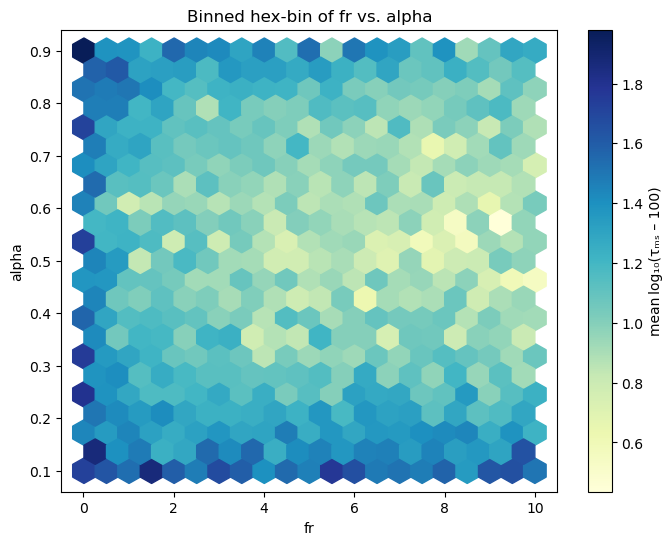

In [128]:
x = acf_full_plot_df['fr']
y = acf_full_plot_df['alpha']
z = np.log10(np.abs(acf_full_plot_df['tau_ms'] - 100))

plt.figure(figsize=(8,6))
hb = plt.hexbin(
    x, y,
    C=z,
    reduce_C_function=np.median,   # aggregate by mean
    gridsize=20,                 # adjust bin resolution
    cmap='YlGnBu',
    mincnt=1                     # hide empty bins
)
cb = plt.colorbar(hb)
cb.set_label('mean log₁₀(τₘₛ – 100)')
plt.xlabel('fr')
plt.ylabel('alpha')
plt.title('Binned hex‐bin of fr vs. alpha')
plt.show()

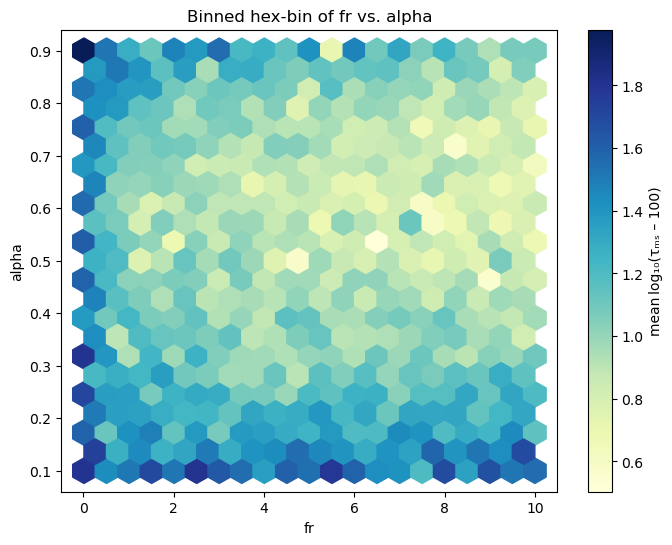

In [129]:
x = acf_isttc_full_plot_df['fr']
y = acf_isttc_full_plot_df['alpha']
z = np.log10(np.abs(acf_isttc_full_plot_df['tau_ms'] - 100))

plt.figure(figsize=(8,6))
hb = plt.hexbin(
    x, y,
    C=z,
    reduce_C_function=np.median,   # aggregate by mean
    gridsize=20,                 # adjust bin resolution
    cmap='YlGnBu',
    mincnt=1                     # hide empty bins
)
cb = plt.colorbar(hb)
cb.set_label('mean log₁₀(τₘₛ – 100)')
plt.xlabel('fr')
plt.ylabel('alpha')
plt.title('Binned hex‐bin of fr vs. alpha')
plt.show()

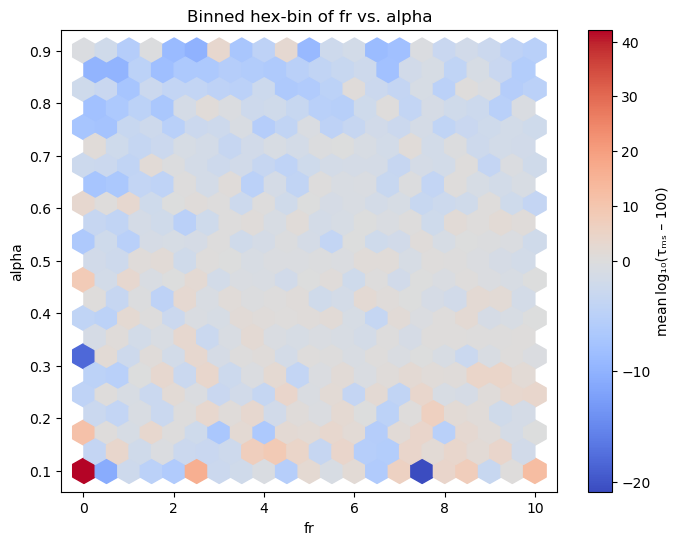

In [124]:
x = acf_isttc_full_plot_df['fr']
y = acf_isttc_full_plot_df['alpha']
z = np.abs(acf_isttc_full_plot_df['tau_ms'] - 100) - np.abs(acf_full_plot_df['tau_ms'] - 100)

norm = TwoSlopeNorm(vcenter=0)


plt.figure(figsize=(8,6))
hb = plt.hexbin(
    x, y,
    C=z,
    reduce_C_function=np.median,   # aggregate by mean
    gridsize=20,                 # adjust bin resolution
    cmap='coolwarm',
    norm = norm,
    mincnt=1                     # hide empty bins
)
cb = plt.colorbar(hb)
cb.set_label('mean log₁₀(τₘₛ – 100)')
plt.xlabel('fr')
plt.ylabel('alpha')
plt.title('Binned hex‐bin of fr vs. alpha')
plt.show()

In [127]:
np.count_nonzero(z <= 0)/len(z)

0.5632

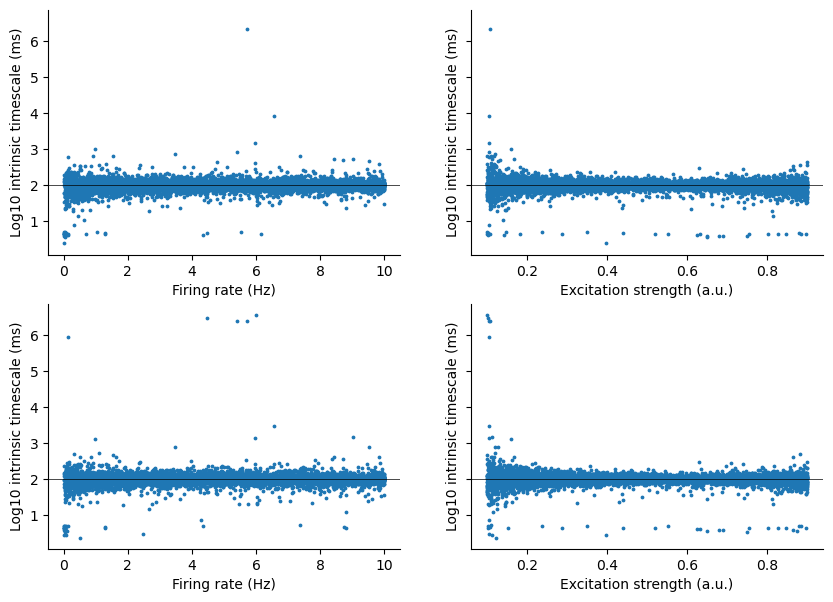

In [92]:
fig, axes = plt.subplots(2,2, figsize=(10, 7), sharey=True)


axes[0,0].scatter(acf_full_plot_df['fr'], np.log10(acf_full_plot_df['tau_ms']), s=3)
axes[0,1].scatter(acf_full_plot_df['alpha'], np.log10(acf_full_plot_df['tau_ms']), s=3)

axes[1,0].scatter(acf_isttc_full_plot_df['fr'], np.log10(acf_isttc_full_plot_df['tau_ms']), s=3)
axes[1,1].scatter(acf_isttc_full_plot_df['alpha'], np.log10(acf_isttc_full_plot_df['tau_ms']), s=3)

axes[0,0].set_xlabel('Firing rate (Hz)')
axes[1,0].set_xlabel('Firing rate (Hz)')

axes[0,1].set_xlabel('Excitation strength (a.u.)')
axes[1,1].set_xlabel('Excitation strength (a.u.)')

for ax in axes.flat:
    ax.axhline(y=2, lw=0.5, c='k')
    ax.set_ylabel('Log10 intrinsic timescale (ms)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var.svg' , bbox_inches='tight')

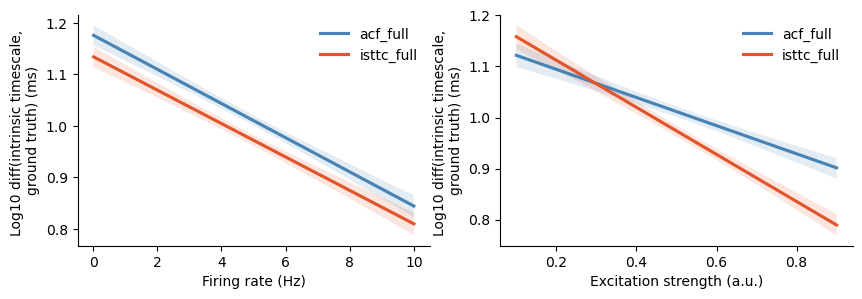

In [93]:
fig, axes = plt.subplots(1,2, figsize=(10, 3), sharey=False)

sns.regplot(x=acf_full_plot_df['fr'].values, y=np.log10(np.abs(acf_full_plot_df['tau_ms'] - 100)), scatter=None, ax=axes[0], 
            label='acf_full', color=color_acf_full)
sns.regplot(x=acf_full_plot_df['fr'].values, y=np.log10(np.abs(acf_isttc_full_plot_df['tau_ms'] - 100)), scatter=None, ax=axes[0], 
            label='isttc_full', color=color_isttc_full)
axes[0].legend(frameon=False)

sns.regplot(x=acf_full_plot_df['alpha'].values, y=np.log10(np.abs(acf_full_plot_df['tau_ms'] - 100)), scatter=None, ax=axes[1], 
            label='acf_full', color=color_acf_full)
sns.regplot(x=acf_full_plot_df['alpha'].values, y=np.log10(np.abs(acf_isttc_full_plot_df['tau_ms'] - 100)), scatter=None, ax=axes[1], 
            label='isttc_full', color=color_isttc_full)
axes[1].legend(frameon=False)


axes[0].set_xlabel('Firing rate (Hz)')
axes[1].set_xlabel('Excitation strength (a.u.)')

for ax in axes.flat:
    ax.set_ylabel('Log10 diff(intrinsic timescale, \nground truth) (ms)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff.svg' , bbox_inches='tight')

### ZZZ

##### Example plot for panel B

In [ ]:
n_trials_impl = 50
random_trials_impl_l = []
for i in range(n_trials_impl):
    random_trials_impl_l.append(random.choices(range(0, 100), k=1000))

In [ ]:
# df for example plot
random_trials_impl = random_trials_impl_l[10]

acf_pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, acf_cols[:-1], 'pearsonr_trial_avg', random_trials_impl)
acf_sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, acf_cols[:-1], 'sttc_trial_concat', random_trials_impl)
acf_sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, acf_cols[:-1], 'sttc_trial_avg', random_trials_impl)

tau_concat_one_ex_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_plot_df, acf_sttc_trial_avg_plot_df, acf_sttc_trial_concat_plot_df])
tau_concat_one_ex_df['log_tau'] = np.log10(tau_concat_one_ex_df['tau_ms'])
tau_concat_one_ex_df.reset_index(inplace=True, drop=True)

tau_concat_one_ex_df = tau_concat_one_ex_df[['unit_id', 'tau', 'tau_lower', 
                                             'tau_upper', 'fit_r_squared','decline_150_250', 'method', 'tau_ms','log_tau']].copy()
tau_concat_one_ex_df

In [ ]:
fig, axes = joypy.joyplot(data=tau_concat_one_ex_df,
    by='method',
    column='log_tau',
    range_style='own',
    grid="y",
    kind='kde',
    overlap=2,
    alpha=0.5,
    linewidth=1,
    x_range=[-2,9]
)

axes[-1].axvline(x=2, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('40 1000ms trials vs full signal, tau = 100ms')

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods.svg' , bbox_inches='tight')

In [ ]:
# your long‐form DataFrame
df = tau_concat_one_ex_df.copy()

# define your intervals (you listed four)
intervals = {
    '0–200':   (0,   200),
    '25–175':  (25,  175),
    '50–150':  (50,  150),
    '75–125':  (75,  125),
}

# build a per-method percentage table
rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

percent_df = pd.DataFrame(rows).set_index('method')
percent_df

In [ ]:
percent_df = percent_df.reset_index()
percent_long = percent_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
percent_long

In [ ]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, percent_long)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_one_trials_impl.svg' , bbox_inches='tight')

#### Plot

In [ ]:
dfs = []

for idx, random_trials_impl in enumerate(random_trials_impl_l):
    # build each method’s DataFrame for this particular impl
    df_p = get_trials_plot_df(pearsonr_trial_avg_dict,
                              acf_cols[:-1],
                              'pearsonr_trial_avg',
                              random_trials_impl)
    df_sa = get_trials_plot_df(sttc_trial_avg_dict,
                               acf_cols[:-1],
                               'sttc_trial_avg',
                               random_trials_impl)
    df_sc = get_trials_plot_df(sttc_trial_concat_dict,
                               acf_cols[:-1],
                               'sttc_trial_concat',
                               random_trials_impl)
    
    # also include the “full” methods (assuming these don’t depend on the random_trials_impl)
    df_full = acf_full_plot_df.copy()
    df_isttc = acf_isttc_full_plot_df.copy()
    
    # concatenate all methods for this one example
    one_ex = pd.concat([df_full,
                        df_isttc,
                        df_p,
                        df_sa,
                        df_sc],
                       ignore_index=True)
    
    # compute log_tau and reorder columns
    one_ex['log_tau'] = np.log10(one_ex['tau_ms'])
    one_ex = one_ex[['unit_id', 'tau', 'tau_lower', 'tau_upper',
                     'fit_r_squared', 'decline_150_250',
                     'method', 'tau_ms', 'log_tau']]
    
    # tag with which random_trials_impl index this came from
    one_ex['random_trials_impl_idx'] = idx
    
    dfs.append(one_ex)

# merge them all into one long DataFrame
tau_concat_all_ex_df = pd.concat(dfs, ignore_index=True)

# quick sanity check
print(tau_concat_all_ex_df.shape)
print(tau_concat_all_ex_df['random_trials_impl_idx'].nunique(), 'unique impls')

In [ ]:
tau_concat_all_ex_df

In [ ]:
# your big long df
df = tau_concat_all_ex_df.copy()

# define the intervals you care about
intervals = {
    '0–200':  (0,   200),
    '25–175': (25,  175),
    '50–150': (50,  150),
    '75–125': (75,  125),
}

rows = []
# loop over each resampling impl and each method
for idx, df_idx in df.groupby('random_trials_impl_idx'):
    total_idx = len(df_idx)
    for method, df_m in df_idx.groupby('method'):
        total_m = len(df_m)
        for name, (lo, hi) in intervals.items():
            cnt = df_m['tau_ms'].between(lo, hi).sum()
            rows.append({
                'random_trials_impl_idx': idx,
                'method': method,
                'interval': name,
                'percentage': cnt/total_m * 100
            })

percent_long = pd.DataFrame(rows)
percent_long

In [ ]:
summary_df = (
    percent_long
    .groupby(['method','interval'])['percentage']
    .agg(
        median = 'mean',
        lower_95 = lambda x: x.quantile(0.025),
        upper_95 = lambda x: x.quantile(0.975)
    )
    .reset_index()
)
summary_df = summary_df.rename(columns={'median': 'percentage'})
summary_df

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, summary_df)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_50_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_50_trials_impl.svg' , bbox_inches='tight')

##### t

In [ ]:
acf_pearsontr_trial_avg_df = get_trials_plot_df(pearsonr_trial_avg_dict, acf_cols[:-1], 'pearsonr_trial_avg')
acf_sttc_trial_concat_df = get_trials_plot_df(sttc_trial_concat_dict, acf_cols[:-1], 'sttc_trial_concat')
acf_sttc_trial_avg_df = get_trials_plot_df(sttc_trial_avg_dict, acf_cols[:-1], 'sttc_trial_avg')

acf_pearsontr_trial_avg_df_med = acf_pearsontr_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_concat_df_med = acf_sttc_trial_concat_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_avg_df_med = acf_sttc_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()

tau_concat_avg_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_df_med, acf_sttc_trial_concat_df_med, acf_sttc_trial_avg_df_med])
tau_concat_avg_df['log_tau'] = np.log10(tau_concat_avg_df['tau_ms'])
tau_concat_avg_df.reset_index(inplace=True, drop=True)

tau_concat_avg_df = tau_concat_avg_df[['unit_id', 'method', 'tau_ms','log_tau']].copy()
tau_concat_avg_df

In [ ]:
# your long‐form DataFrame
df = tau_concat_avg_df.copy()

# define your intervals (you listed four)
intervals = {
    '0–200':   (0,   200),
    '25–175':  (25,  175),
    '50–150':  (50,  150),
    '75–125':  (75,  125),
}

# build a per-method percentage table
rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

percent_avg100_df = pd.DataFrame(rows).set_index('method')
percent_avg100_df

In [ ]:
percent_avg100_df = percent_avg100_df.reset_index()
percent_avg_long = percent_avg100_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
percent_avg_long

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, percent_avg_long)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_med_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_med_trials_impl.svg' , bbox_inches='tight')

### ZZZ

In [ ]:
tau_concat_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_plot_df, acf_sttc_trial_avg_plot_df, acf_sttc_trial_concat_plot_df])
tau_concat_df.reset_index(inplace=True, drop=True)
tau_concat_df['ground_truth_diff'] = tau_concat_df['tau_ms'] - target_tau_ms
tau_concat_df['ground_truth_diff_abs'] = np.abs(tau_concat_df['ground_truth_diff'])
tau_concat_df

In [ ]:
tau_concat_df.query('tau_ms < 125 and tau_ms > 25').groupby(by='method', as_index=False).count()

In [ ]:
tau_concat_df.query('tau_ms < 125 and tau_ms > 75').groupby(by='method', as_index=False).median()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='tau_ms', data=tau_concat_df, cut=0,  density_norm='width')
axes.axhline(y=target_tau_ms, color='k')

axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
plt.figure(figsize=(6,4))
sns.ecdfplot(
    data=tau_concat_df,
    x='tau_ms',
    hue='method',
    stat='proportion'
)
plt.xscale('log')
plt.xlabel('tau_ms')
plt.ylabel('Cumulative proportion')
plt.title('ECDF of tau_ms by Method')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.boxenplot(
    data=tau_concat_df,
    y='method',
    x='tau_ms',
    k_depth='tukey',   # more letter‐values
    palette='Set2'
)
plt.xscale('log')
plt.ylabel('tau_ms (log scale)')
plt.xlabel('Method')
plt.title('Boxenplot of τ by Method')
plt.tight_layout()
plt.show()

In [ ]:
# 1) add a log‐τ column
df = tau_concat_df.copy()
df['log_tau'] = np.log10(df['tau_ms'] + 1e-6)

# 2) fix the plotting order so the first two come first
order = ['acf_full',
         'isttc_full',
         'pearsonr_trial_avg',
         'sttc_trial_avg',
         'sttc_trial_concat']

# 3) make the joyplot
fig, axes = joypy.joyplot(
    data      = df,
    by        = 'method',
    column    = 'log_tau',
    kind      = 'kde',
    overlap   = 0.2,           # small global overlap
    range_style = 'own',       # each row gets its *own* x‐range
    fade      = True,
    linewidth = 1,
    figsize   = (6, 5),
    title     = "Ridge Plot of log10(τ) by Method",
)

# 4) yank the first two axes further apart so they *never* overlap
#    (they’re very narrow, so even a little extra space is enough)
for ax in axes[:2]:
    ax.set_ylim(0, ax.get_ylim()[1])  # reset bottom to zero
    ax.margins(y=0.3)                  # add extra headroom

plt.xlabel("log10(τ_ms)")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff', data=tau_concat_df.query('tau_ms < 150 and tau_ms > 50'), cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff_abs', data=tau_concat_df.query('tau_ms < 150 and tau_ms > 50'), cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15,5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes,
    data=tau_concat_df,
    x='tau_ms',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)

axes.set_xscale('log')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df.query('tau_ms < 200'),
    x='tau_ms',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_pearsontr_trial_avg_plot_df['tau_ms'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_sttc_trial_avg_plot_df['tau_ms'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.axvline(x=target_tau_ms, color='black', lw=0.5)
    #ax.set_xlim([25, 225])
    ax.set_xlabel('Intrinsic timescale (ms)')

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df,
    x='fit_r_squared',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_full_plot_df['fit_r_squared'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
#axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_isttc_full_plot_df['fit_r_squared'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
#axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.set_xlim([0, 1])
    ax.set_xlabel('R-squared')

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.scatterplot(ax=axes[0], x=tau_concat_df.query('method == "pearsonr_trial_avg"')['tau_ms'].values, 
             y=tau_concat_df.query('method == "sttc_trial_concat"')['tau_ms'].values, s=2)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes, lw=0.5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('ACF tau')
axes[0].set_ylabel('iSTTC tau')
axes[0].set_xlim([25, 225])
axes[0].set_ylim([25, 225])
axes[0].axvline(x=target_tau_ms, lw=1, c='salmon')
axes[0].axhline(y=target_tau_ms, lw=1, c='salmon')
axes[0].grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(ax=axes[1], x=tau_concat_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'].values, 
             y=tau_concat_df.query('method == "sttc_trial_concat"')['fit_r_squared'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes, lw=0.5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('ACF R-squared')
axes[1].set_ylabel('iSTTC R-squared')
# axes[1].set_xlim([0.8, 1])
# axes[1].set_ylim([0.8, 1])
axes[1].grid(True, linestyle='--', alpha=0.5)

r_squared_diff = tau_concat_df.query('method == "sttc_trial_concat"')['fit_r_squared'].values - tau_concat_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'].values
n_sttc_better = sum(r_squared_diff > 0)
n_sttc_better_perc = n_sttc_better / len(r_squared_diff) * 100

sns.histplot(ax=axes[2], x=r_squared_diff, stat='probability', bins=20, kde=False, color='steelblue', alpha=0.5)
axes[2].axvline(x=0, lw=1, c='salmon')
axes[2].set_xlabel('STTC R-squared - \nACF R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

#fig.suptitle('sttc vs acf, allen, n_units = ' + str(len(r_squared_diff)), y=1.15)

sns.despine()


#### Tests